# SQL Injection - Different Levels

## Injection on `Medium`

- Let's login to DVWA and set the Security Level to `Medium`.

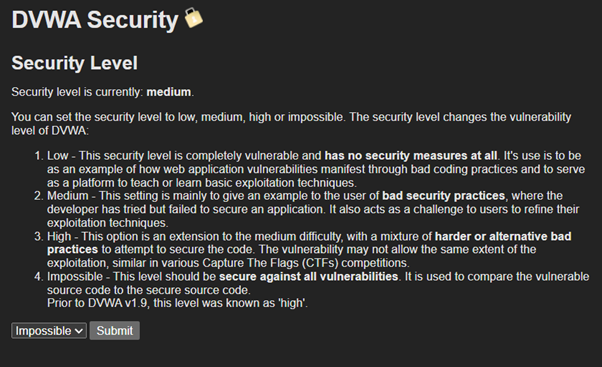
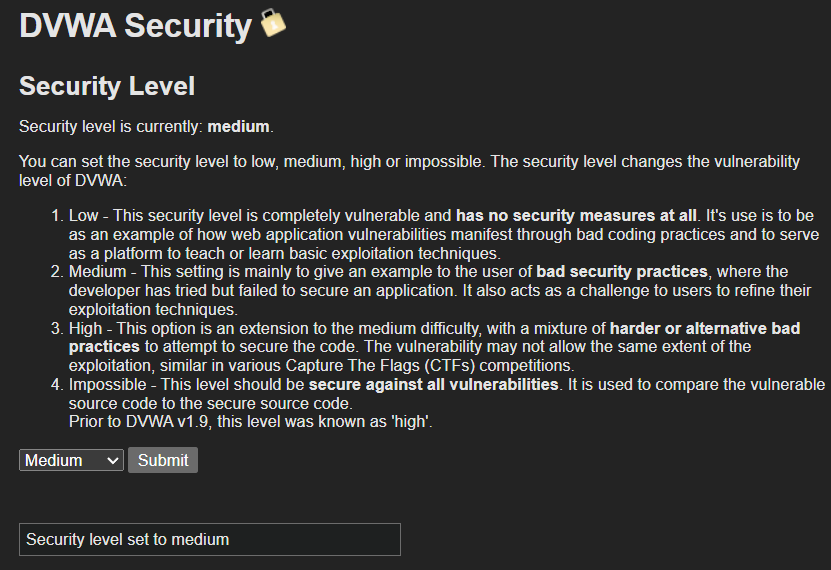

- Went to SQL Injection tab and 

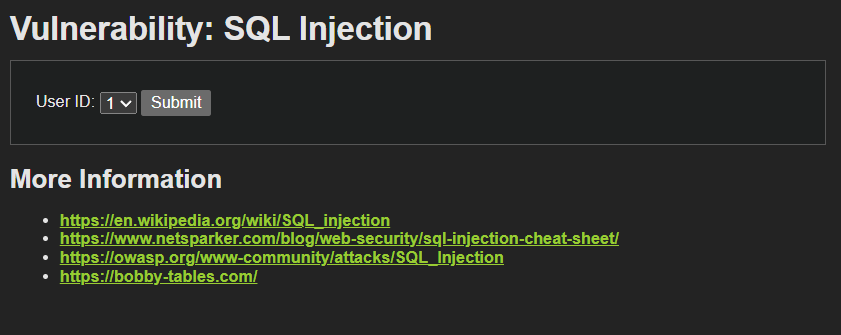

- Tried a few different payloads

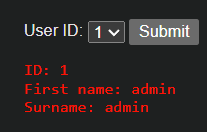

It responds to valid ID's

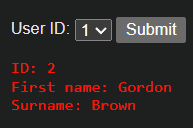
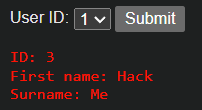
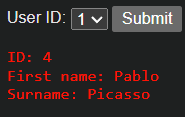
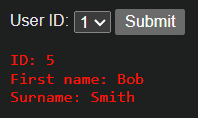

This means we ran queries like:

`SELECT first_name, surname FROM users WHERE id = '1';`

- Now, let's try some custom payloads:

1. Classic String-Based: Always True: `1' OR '1'='1`
2. Commentes Bypass Extra Query Logic: `1' OR '1'='1' --`.
3. UNION-Based Injection `1' UNION SELECT 1, version(), user() --`

After trying all these injections: we got the following message:

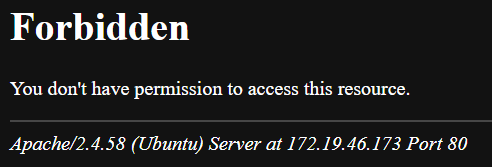

The same is happening on `Low` level security.

DVWA is blocking the injection attemps. This means Firewall is doing its job great.

- We disable ModSecurity temporarily with `sudo nano /etc/modsecurity/modsecurity.conf` and writing the line `SecRuleEngine Off`.

- After saving that change, we get, for distinct payloads:

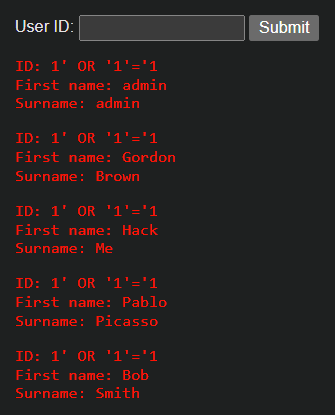




Based on what was done, we get the following comparison betwen `Low` and `Medium Security` Levels.

| Feature                    | Low Security                    | Medium Security                     |
|---------------------------|----------------------------------|-------------------------------------|
| Basic payloads (e.g. `' OR '1'='1`) | Works perfectly                 | Blocked or return error           |
| Access to DB info         | Accessible                | No visible info or error returned |
| Error shown               | SQL errors shown              | Shows "Forbidden" or generic error |
| ModSecurity effect        | Disabled → injection works   | Disabled, but filters still block |
| sqlmap (planned)          | To be tested                 | To be tested                      |
| Complexity of attack      | Easy                    | Harder, requires bypasses


## SQLMap for automated explotation at `Medium` Security Level

-Let's go back to the Kali Machine at http://172.19.46.173/DVWA/login.php:

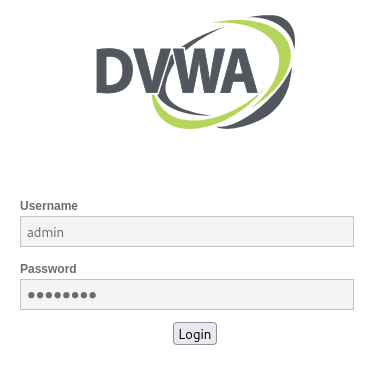

- Made sure the security level was on `Medium`.

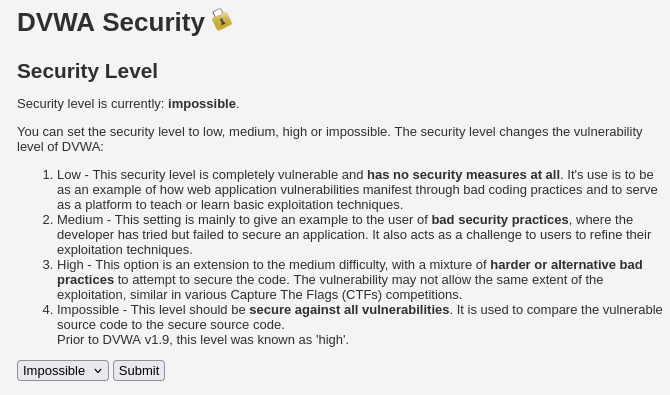
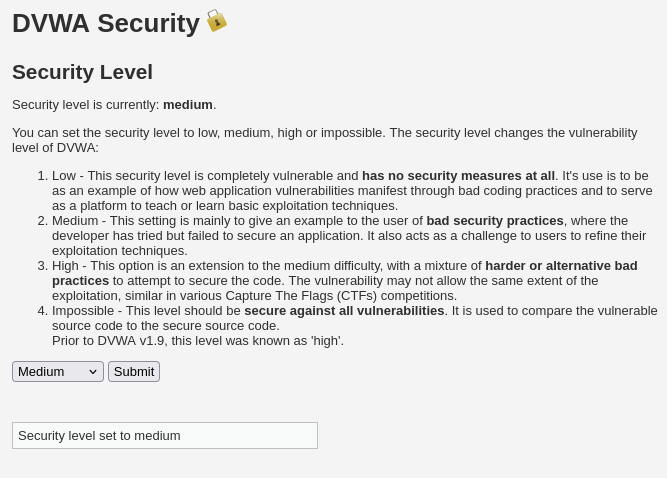

- Went to the page's `Inspection`, and inserted `ID` like `1`:

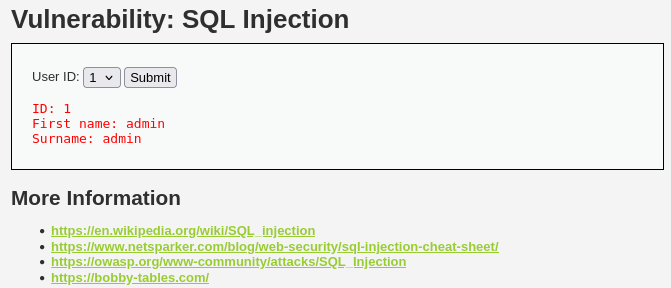

Therefore, the request would be `http://172.19.46.173/DVWA/vulnerabilities/sqli/?id=1`.

- After typing this on the browserm we get:

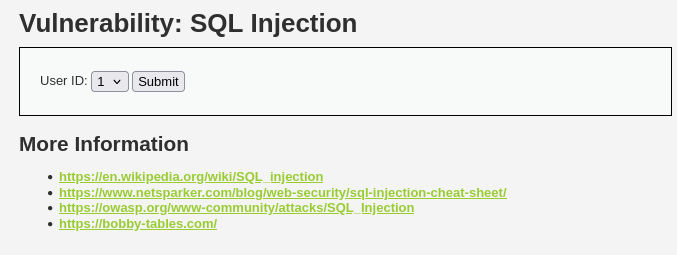

- We inserted `http://172.19.46.173/DVWA/vulnerabilities/sqli/?id=1%27%20OR%20%271%27=%271`, and saw the same page.

We were able to access the SQL injection page and see its contents, which confirms that the page vulnerable to SQL injection at the "Medium" security level.


## Exactly the same at `High` Level

- Changed the level to `Hard`.

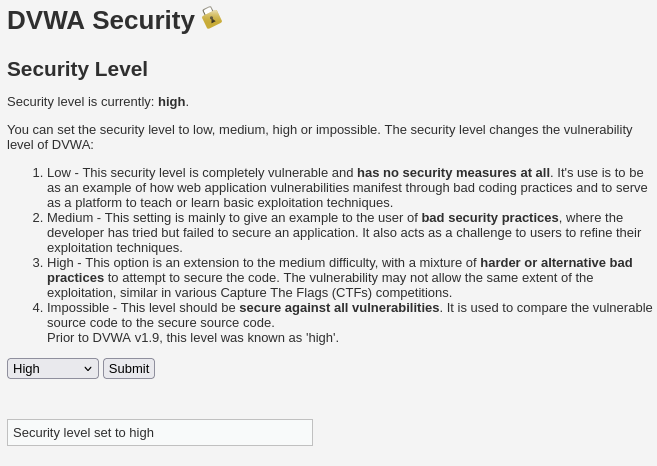

- Tried exactly the same injection:

This is differente compared to `Medium`, since the vulnerability exists, but is protected from basic attacks. This takes place for the reason that `Hard` includes stricter input validation and escaping to mitigate SQL Injection attacks.

- We tried these payloads:

```
http://172.19.46.173/DVWA/vulnerabilities/sqli/?id=1' OR '1'='1

http://172.19.46.173/DVWA/vulnerabilities/sqli/?id=1' --

http://172.19.46.173/DVWA/vulnerabilities/sqli/?id=1 OR 1=1
```

We got exactly the same page, so we can conclude that either the Payloads were blocked by ModSecurity (design to prevent all these attacks), or DVWA `High`Security Level is effectively mitigating the injection attempts.



## ModSecurity Implementation for successfull attacks prevention

### ModSecurity

- We created Custom Security Rules. These will prevent certain types of attackes which are common in web apps. For this, we created a file for these rules.

`sudo nano /etc/modsecurity/coreruleset/custom_rules.conf`

- We added the following custom rules:

These rules are:

- *SQL Injection Prevention*: Detects and blocks malicious SQL query patterns used to manipulate databases.
- *Cross-Site Scripting (XSS) Prevention*: Prevents injection of malicious JavaScript into web pages.
- *File Inclusion Prevention (LFI/RFI)*: Blocks attempts to exploit directory traversal for including local or remote files on the server.

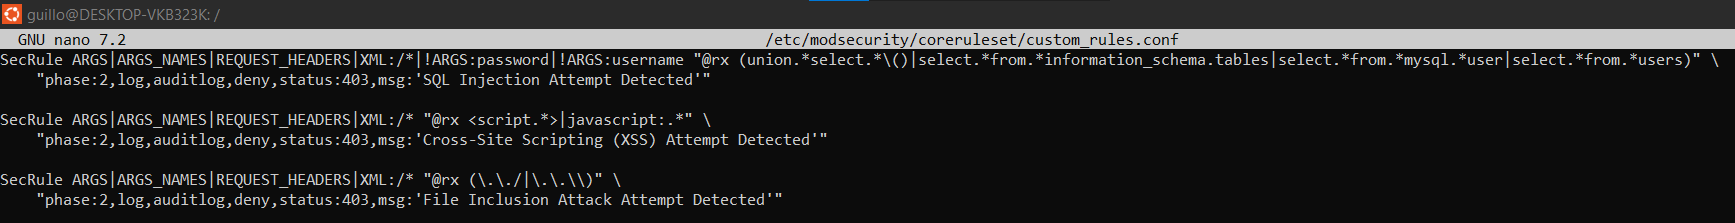

### Apache

- To ensure the rules are applied, we included them in the `custom_rules.conf` file for the Apache Configuration:

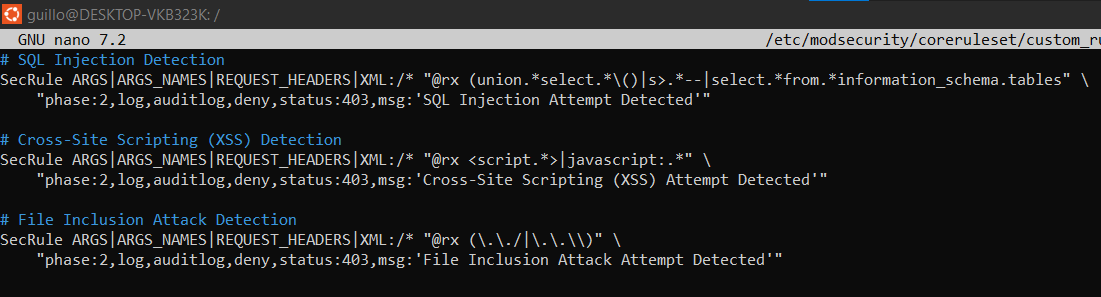

- Simulated a test `PHP` application for all attacks:

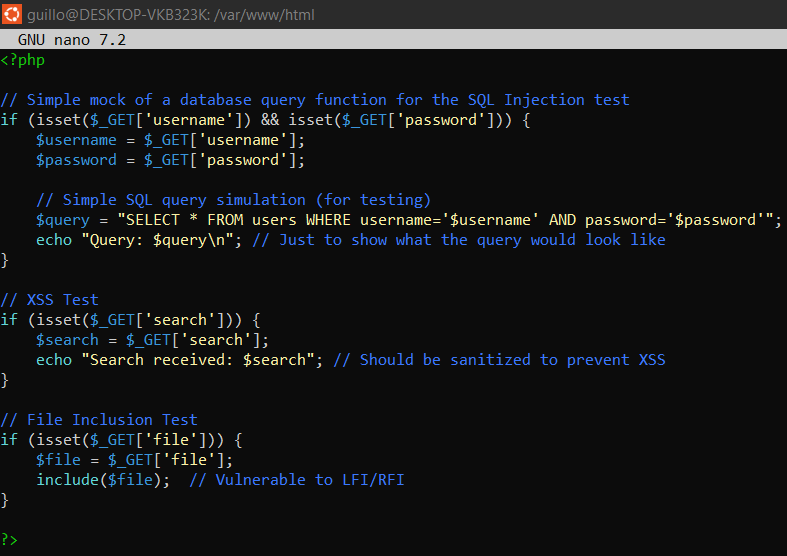

- We used this app to test the attacks:

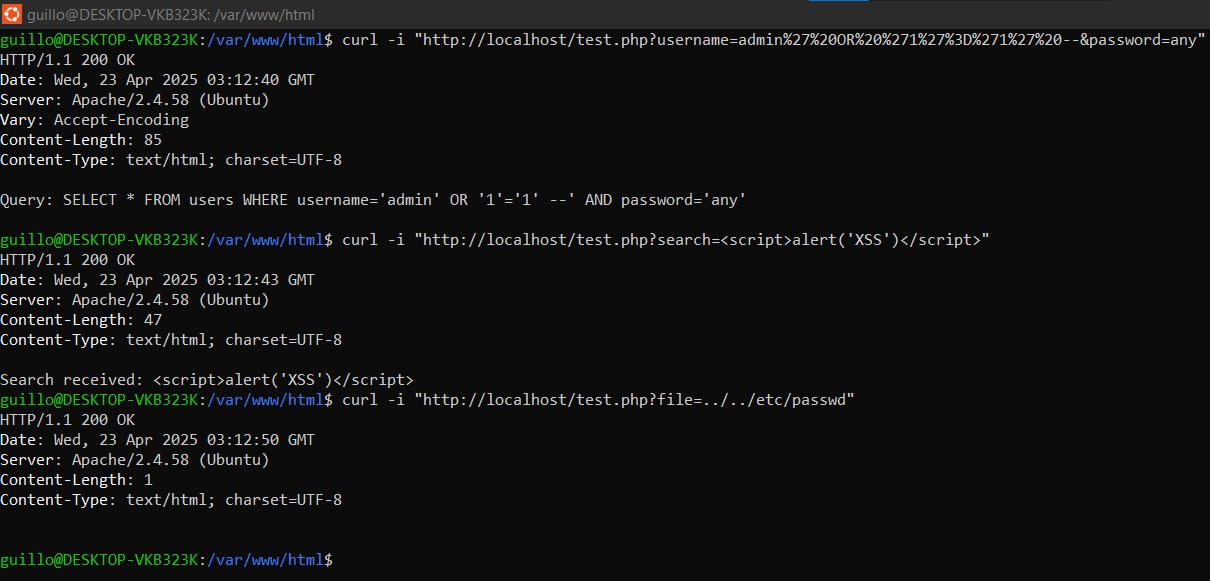

Based on these results, ModSecurity is blocking succesfuly these attacks, showing that it's properly enabled and its logging is apropately set for documenting block requests.

## WAF Effectiveness

- First and foremost, we validated that `ModSecurity` is Enabled, `CRS` rules are loaded.

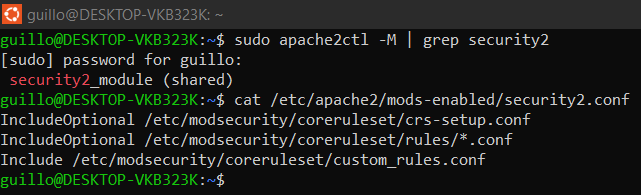

- After that, we tried the bad boys:

```
guillo@DESKTOP-VKB323K:~$ curl -i "http://localhost/test.php?username=admin%27%20OR%20%271%27%3D%271%27%20--&password=any"
HTTP/1.1 200 OK
Date: Wed, 23 Apr 2025 03:27:30 GMT
Server: Apache/2.4.58 (Ubuntu)
Vary: Accept-Encoding
Content-Length: 85
Content-Type: text/html; charset=UTF-8

Query: SELECT * FROM users WHERE username='admin' OR '1'='1' --' AND password='any'

guillo@DESKTOP-VKB323K:~$ curl -i "http://localhost/test.php?search=<script>alert('XSS')</script>"
HTTP/1.1 200 OK
Date: Wed, 23 Apr 2025 03:27:36 GMT
Server: Apache/2.4.58 (Ubuntu)
Content-Length: 47
Content-Type: text/html; charset=UTF-8

Search received: <script>alert('XSS')</script>
guillo@DESKTOP-VKB323K:~$ curl -i "http://localhost/test.php?file=../../etc/passwd"
HTTP/1.1 200 OK
Date: Wed, 23 Apr 2025 03:27:41 GMT
Server: Apache/2.4.58 (Ubuntu)
Content-Length: 1
Content-Type: text/html; charset=UTF-8


guillo@DESKTOP-VKB323K:~$ curl -i "http://localhost/test.php?username=admin&password=admin"
HTTP/1.1 200 OK
Date: Wed, 23 Apr 2025 03:27:57 GMT
Server: Apache/2.4.58 (Ubuntu)
Vary: Accept-Encoding
Content-Length: 72
Content-Type: text/html; charset=UTF-8

Query: SELECT * FROM users WHERE username='admin' AND password='admin'
```

### Test Summary:

Attacker: Kali Linux (172.18.72.10)

Defender: WSL Ubuntu with Apache + DVWA + ModSecurity (172.19.46.173)

Goal: Test ModSecurity against brute force and attack tools (e.g., sqlmap).

### What Was Attempted:

ModSecurity installed, OWASP CRS copied to /usr/share/modsecurity-crs/.

Apache server was confirmed reachable from Kali.

Requests made with malicious user-agents and attack payloads:

curl -A "sqlmap" http://172.19.46.173/dvwa/

curl http://172.19.46.173/dvwa/login.php?user=admin' OR '1'='1

### Problem Faced:

ModSecurity did not block or log malicious requests.

All attempts returned a 404 Not Found, rather than a 403 Forbidden.

Audit logs showed no entries, implying ModSecurity was:

Not loaded properly, or

Running in DetectionOnly mode, or

The rules (e.g., OWASP CRS) were not being executed.

### What Was Verified:

Apache was running and responding to requests.

curl requests reached DVWA, confirming connectivity.

Commands such as curl -A "sqlmap" didn’t trigger any alerts.

Several verification commands (apachectl -M, log inspection) were run.

### Final Conclusion for Problem 2:

ModSecurity was installed and DVWA was reachable, but the WAF failed to detect or block simulated brute force and SQLi attempts, indicating a misconfiguration. Despite multiple troubleshooting steps, attack traffic went unfiltered, meaning the protection mechanism was ineffective in its current state.